In [1]:
import pandas as pd
import numpy as np

## Load Data

In [2]:
# Read in the sessions table
# Drop app_id, device_id, timezone_offset, latitude, longitude and locale columns

session_path = '/Users/jialiang.shi/data/leanplum/sessions.csv'

session_dtype = {'session_id':'category', 'start_timestamp':np.uint64, 'timezone':'category', 
                 'previous_sessions_duration':np.uint32, 'user_created_timestamp':np.uint64,
                 'is_user_first_session':np.bool, 'is_session':np.bool, 'is_developer':np.bool, 
                 'is_wau':np.bool, 'is_mau':np.bool, 'country':'category', 'region':'category', 
                 'city':'category', 'os_name':'category', 'session_index':np.uint16, 'user_id_hash':'category'}

sessions = pd.read_csv(session_path, usecols=session_dtype.keys(), dtype=session_dtype)


In [3]:
# Session table filter
sessions = sessions[(sessions.is_session == True) & (sessions.is_wau == False)\
                    & (sessions.is_mau == False) & (sessions.is_developer == False)]
sessions.drop_duplicates(inplace=True)

In [4]:
sessions['start_timestamp']=pd.to_datetime(sessions.start_timestamp, unit='ms')  

In [5]:
# Read in the events table
# Drop app_id columns

event_path = '/Users/jialiang.shi/data/leanplum/events.csv'
event_dtype = {'session_id': 'category', 'event': 'category', 'event_timestamp': np.uint64,
               'event_value': np.float32, 'user_id_hash': 'category'}

events = pd.read_csv(event_path, usecols=event_dtype.keys(), dtype=event_dtype)

In [6]:
# Drop duplicates and add Timestamp
events.drop_duplicates(inplace=True)
events['event_timestamp']=pd.to_datetime(events.event_timestamp, unit='ms')  

In [7]:
all_users = events['user_id_hash'].unique()

## Generate Label

In [7]:
# event_data = events.loc[events.event_timestamp < '2018-12-01 00:00']
# purchase_14 = events.loc[events.event_timestamp > '2018-12-01 00:00']
# purchase_7 = purchase_14.loc[purchase_14.event_timestamp < '2018-12-08 00:00']
# userID_7 = purchase_7.loc[purchase_7.event=='8'].user_id_hash.unique()
# userID_14 = purchase_14.loc[purchase_14.event=='8'].user_id_hash.unique()
# target = [(x, (x in userID_7), (x in userID_14)) for x in all_users]
# target_df = pd.DataFrame(target, columns=['user_id_hash', 'one_week_purchase', 'two_week_purchase'])
# target_df.to_csv('target.csv', index=False)

In [8]:
target_df = pd.read_csv('target.csv')

In [9]:
target_df.head()

,user_id_hash,one_week_purchase,two_week_purchase
0,9943447915df3a45fd6720a026af905b6da6b56a37701b...,False,False
1,43f75f8042d3c80c45e222bdd09267f4584684c54d6fae...,False,False
2,999524249720812f2d8c0390293efd58e1ac84d587a01c...,False,False
3,4e6bc35cf7fd79a5312047651e7865915f4a6bec193cf2...,False,False
4,dc009148ee26d658e0240c7b7f6a258790a457737f96e8...,False,False


In [10]:
len(target_df)

621001

## Purchase counts

In [18]:
event_data = events.loc[events.event_timestamp < '2018-12-01 00:00']

In [19]:
purchase = event_data.loc[event_data.event=='8']
purchase_count = purchase.groupby('user_id_hash')['event'].count().to_frame()
purchase_count = purchase_count.reset_index()

In [20]:
purchase_count = purchase_count.rename(index=str, columns={"event": "purchase_count"})
purchase_count.head()

,user_id_hash,purchase_count
0,002e447aed33ed4c51a68743cc293ef2148058b6a6239e...,0
1,005c9d79cf18efc6c8b5fa767964b1def9b8e2f8abd23f...,0
2,0061b4d30e8a9935b2ebeec954ff509b4f0cb500cd725c...,0
3,00fbbf507c7d3c2f259cd3329d241c29d35712e2d4699f...,0
4,0107a0017873efc2dea9a9155832363ceacf6fe97bd428...,0


In [22]:
len(purchase_count)

621001

## Sum and Mean Purchase 

In [25]:
purchase_value = purchase.groupby('user_id_hash')['event_value'].agg(['sum', 'mean'])\
                     .rename(columns={'sum': 'sum_value', 'mean': 'mean_value'})

In [27]:
purchase_value.mean_value.fillna(0, inplace=True)
purchase_value.isna().any()

sum_value     False
mean_value    False
dtype: bool

In [28]:
purchase_value.head()

,sum_value,mean_value
user_id_hash,,
002e447aed33ed4c51a68743cc293ef2148058b6a6239e37d013cc6dc49bdfdf,0.0,0.0
005c9d79cf18efc6c8b5fa767964b1def9b8e2f8abd23f453310f60d69584a9f,0.0,0.0
0061b4d30e8a9935b2ebeec954ff509b4f0cb500cd725c1aa7145841c82d907c,0.0,0.0
00fbbf507c7d3c2f259cd3329d241c29d35712e2d4699f5c6a51d5149219ecee,0.0,0.0
0107a0017873efc2dea9a9155832363ceacf6fe97bd428a73efa67b639962ac0,0.0,0.0


## Last 7 days and 14 days purchase data

In [29]:
last_7_events = events.loc[(events.event_timestamp < '2018-12-01 00:00') & (events.event_timestamp > '2018-11-24 00:00')]
last_14_events = events.loc[(events.event_timestamp < '2018-12-01 00:00') & (events.event_timestamp > '2018-11-17 00:00')]


In [30]:
purchase_7 = last_7_events.loc[last_7_events.event=='8']
purchase_count_7 = purchase_7.groupby('user_id_hash')['event'].count().to_frame()
purchase_count_7 = purchase_count_7.reset_index()
purchase_count_7 = purchase_count_7.rename(index=str, columns={"event": "purchase_count_7"})

In [32]:
purchase_value_7 = last_7_events.groupby('user_id_hash')['event_value'].agg(['sum', 'mean'])\
                     .rename(columns={'sum': 'sum_value_7', 'mean': 'mean_value_7'})

In [35]:
purchase_value_7.fillna(0, inplace=True)
purchase_value_7.isna().any()

sum_value_7     False
mean_value_7    False
dtype: bool

In [31]:
purchase_14 = last_14_events.loc[last_14_events.event=='8']
purchase_count_14 = purchase_14.groupby('user_id_hash')['event'].count().to_frame()
purchase_count_14 = purchase_count_14.reset_index()
purchase_count_14 = purchase_count_14.rename(index=str, columns={"event": "purchase_count_14"})

In [33]:
purchase_value_14 = last_14_events.groupby('user_id_hash')['event_value'].agg(['sum', 'mean'])\
                     .rename(columns={'sum': 'sum_value_14', 'mean': 'mean_value_14'})

In [36]:
purchase_value_14.fillna(0, inplace=True)
purchase_value_14.isna().any()

sum_value_14     False
mean_value_14    False
dtype: bool

## Purchase Nonpurchase ratio per user

In [37]:
pur_npur_ratio = event_data[event_data.event=='8'].groupby('user_id_hash').size()/event_data.groupby('user_id_hash').size()
pur_npur_ratio = pur_npur_ratio.to_frame().reset_index()
pur_npur_ratio.rename(columns={0: 'ratio'}, inplace=True)


In [38]:
pur_npur_ratio.ratio.fillna(0, inplace=True)

In [39]:
pur_npur_ratio.head()

,user_id_hash,ratio
0,002e447aed33ed4c51a68743cc293ef2148058b6a6239e...,0.0
1,005c9d79cf18efc6c8b5fa767964b1def9b8e2f8abd23f...,0.0
2,0061b4d30e8a9935b2ebeec954ff509b4f0cb500cd725c...,0.0
3,00fbbf507c7d3c2f259cd3329d241c29d35712e2d4699f...,0.0
4,0107a0017873efc2dea9a9155832363ceacf6fe97bd428...,0.0


## Aggregate event data per user

In [40]:
group_event = event_data.groupby('user_id_hash')['event_value'].agg(['sum', 'mean', 'count'])\
            .rename(columns={'sum': 'sum_event', 'mean': 'mean_event_value', 'count': 'count_event'})

In [41]:
group_event.head()

,sum_event,mean_event_value,count_event
user_id_hash,,,
002e447aed33ed4c51a68743cc293ef2148058b6a6239e37d013cc6dc49bdfdf,43.0,0.361345,119
005c9d79cf18efc6c8b5fa767964b1def9b8e2f8abd23f453310f60d69584a9f,12.0,0.500000,24
0061b4d30e8a9935b2ebeec954ff509b4f0cb500cd725c1aa7145841c82d907c,0.0,0.000000,34
00fbbf507c7d3c2f259cd3329d241c29d35712e2d4699f5c6a51d5149219ecee,53.0,1.127660,47
0107a0017873efc2dea9a9155832363ceacf6fe97bd428a73efa67b639962ac0,0.0,0.000000,14


In [42]:
group_event.fillna(0, inplace=True)

In [43]:
len(group_event)

621001

## Aggregate last 7 and 14 days event data per user

In [45]:
group_event_7 = last_7_events.groupby('user_id_hash')['event_value'].agg(['sum', 'mean', 'count'])\
            .rename(columns={'sum': 'sum_event_7', 'mean': 'mean_event_value_7', 'count': 'count_event_7'})

group_event_14 = last_14_events.groupby('user_id_hash')['event_value'].agg(['sum', 'mean', 'count'])\
            .rename(columns={'sum': 'sum_event_14', 'mean': 'mean_event_value_14', 'count': 'count_event_14'})


In [46]:
group_event_7.fillna(0, inplace=True)
group_event_14.fillna(0, inplace=True)

## Aggregate Session Data

In [47]:
sessions.head()

,session_id,start_timestamp,timezone,previous_sessions_duration,user_created_timestamp,is_user_first_session,is_session,is_developer,is_wau,is_mau,country,region,city,os_name,session_index,user_id_hash
0,5558845121177764917,2018-11-14 17:09:24.580,Asia/Manila,25837591,1538874289458,False,True,False,False,False,PH,00,makati,Android OS,30,9943447915df3a45fd6720a026af905b6da6b56a37701b...
1,2201961907282901522,2018-12-02 01:09:37.293,Asia/Manila,35050130,1538874289458,False,True,False,False,False,PH,00,quezon city,Android OS,47,9943447915df3a45fd6720a026af905b6da6b56a37701b...
2,18781111175537580,2018-10-10 23:52:48.666,Asia/Manila,11343848,1538874289458,False,True,False,False,False,PH,00,makati,Android OS,10,9943447915df3a45fd6720a026af905b6da6b56a37701b...
3,1477540082628742048,2018-10-21 11:19:03.010,Asia/Manila,13499724,1538874289458,False,True,False,False,False,PH,11,davao city,Android OS,13,9943447915df3a45fd6720a026af905b6da6b56a37701b...
4,8184875317380844086,2018-11-19 23:53:45.528,Asia/Manila,32788010,1538874289458,False,True,False,False,False,PH,00,makati,Android OS,41,9943447915df3a45fd6720a026af905b6da6b56a37701b...


In [48]:
sessions_data = sessions.loc[sessions.start_timestamp < '2018-12-01 00:00']

In [49]:
grouped = sessions_data.groupby('user_id_hash')
user_agg = grouped['previous_sessions_duration'].agg(['sum', 'mean', 'count'])\
                   .rename(columns={'sum': 'sum_duration', 'mean': 'mean_duration', 'count': 'count_session'})

In [50]:
user_agg.fillna(0, inplace=True)

In [51]:
len(user_agg)

621106

## Aggregate last 7 and 14 days Session Data

In [52]:
last_7_sessions = sessions.loc[(sessions.start_timestamp < '2018-12-01 00:00') & (sessions.start_timestamp > '2018-11-24 00:00')]
last_14_sessions = sessions.loc[(sessions.start_timestamp < '2018-12-01 00:00') & (sessions.start_timestamp > '2018-11-17 00:00')]


In [53]:
grouped_7 = last_7_sessions.groupby('user_id_hash')
user_agg_7 = grouped_7['previous_sessions_duration'].agg(['sum', 'mean', 'count'])\
                   .rename(columns={'sum': 'sum_duration_7', 'mean': 'mean_duration_7', 'count': 'count_session_7'})

grouped_14 = last_14_sessions.groupby('user_id_hash')
user_agg_14 = grouped_14['previous_sessions_duration'].agg(['sum', 'mean', 'count'])\
                   .rename(columns={'sum': 'sum_duration_14', 'mean': 'mean_duration_14', 'count': 'count_session_14'})


In [54]:
user_agg_7.fillna(0, inplace=True)
user_agg_14.fillna(0, inplace=True)

## One-Hot Encoding on OS name

In [55]:
sessions.os_name.value_counts()

Android OS    3360427
iOS           1766212
iPhone OS       39083
Name: os_name, dtype: int64

In [56]:
sessions.os_name.fillna('Android OS', inplace=True)
sessions.loc[sessions.os_name=='iPhone OS', 'os_name'] = 'iOS'

In [57]:
sessions.os_name.value_counts()

Android OS    3360435
iOS           1805295
iPhone OS           0
Name: os_name, dtype: int64

In [58]:
user_os = sessions.groupby('user_id_hash')['os_name'].first()

In [59]:
user_os = user_os.to_frame()

In [60]:
user_os.head()

,os_name
user_id_hash,
0013ae7e9f73194aeb0d350f1de1f441625825efe403c4c7d0a93c304fbf206f,Android OS
0025a6c398e0ec7c471342188141853877f94a76b5127031cc673627dfa921de,iOS
002e3b6443aef897fc35486e072c5781d087943cdb9dff9fbe4eb39d525cc061,iOS
002e447aed33ed4c51a68743cc293ef2148058b6a6239e37d013cc6dc49bdfdf,iOS
005c9d79cf18efc6c8b5fa767964b1def9b8e2f8abd23f453310f60d69584a9f,Android OS


In [61]:
os_enc = pd.get_dummies(user_os.os_name)

In [62]:
os_enc.head()

,Android OS,iOS
user_id_hash,,
0013ae7e9f73194aeb0d350f1de1f441625825efe403c4c7d0a93c304fbf206f,1,0
0025a6c398e0ec7c471342188141853877f94a76b5127031cc673627dfa921de,0,1
002e3b6443aef897fc35486e072c5781d087943cdb9dff9fbe4eb39d525cc061,0,1
002e447aed33ed4c51a68743cc293ef2148058b6a6239e37d013cc6dc49bdfdf,0,1
005c9d79cf18efc6c8b5fa767964b1def9b8e2f8abd23f453310f60d69584a9f,1,0


## Train Test Split

In [69]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn import metrics
from functools import reduce

In [70]:
dfs = [pur_npur_ratio, os_enc, purchase_count, purchase_count_7, purchase_count_14, 
       purchase_value, purchase_value_7, purchase_value_14, 
       group_event, group_event_7, group_event_14, user_agg, user_agg_7, user_agg_14, target_df]

In [71]:
df = reduce(lambda left,right: pd.merge(left,right,on='user_id_hash'), dfs)

In [72]:
df.head()

,user_id_hash,ratio,Android OS,iOS,purchase_count,purchase_count_7,purchase_count_14,sum_value,mean_value,sum_value_7,...,mean_duration,count_session,sum_duration_7,mean_duration_7,count_session_7,sum_duration_14,mean_duration_14,count_session_14,one_week_purchase,two_week_purchase
0,002e447aed33ed4c51a68743cc293ef2148058b6a6239e...,0.0,0,1,0,0,0,0.0,0.0,0.0,...,1889284.25,4,0.0,0.0,0,0.0,0.0,0,False,False
1,005c9d79cf18efc6c8b5fa767964b1def9b8e2f8abd23f...,0.0,1,0,0,0,0,0.0,0.0,0.0,...,0.00,1,0.0,0.0,0,0.0,0.0,0,False,False
2,0061b4d30e8a9935b2ebeec954ff509b4f0cb500cd725c...,0.0,0,1,0,0,0,0.0,0.0,0.0,...,0.00,1,0.0,0.0,0,0.0,0.0,0,False,False
3,00fbbf507c7d3c2f259cd3329d241c29d35712e2d4699f...,0.0,0,1,0,0,0,0.0,0.0,0.0,...,645705.50,2,0.0,0.0,0,0.0,0.0,0,False,False
4,0107a0017873efc2dea9a9155832363ceacf6fe97bd428...,0.0,0,1,0,0,0,0.0,0.0,0.0,...,0.00,1,0.0,0.0,0,0.0,0.0,0,False,False


In [73]:
X = df.iloc[:,1:-2]
y_7 = df['one_week_purchase']
y_14 = df['two_week_purchase']

In [74]:
X.head()

,ratio,Android OS,iOS,purchase_count,purchase_count_7,purchase_count_14,sum_value,mean_value,sum_value_7,mean_value_7,...,count_event_14,sum_duration,mean_duration,count_session,sum_duration_7,mean_duration_7,count_session_7,sum_duration_14,mean_duration_14,count_session_14
0,0.0,0,1,0,0,0,0.0,0.0,0.0,0.0,...,0,7557137.0,1889284.25,4,0.0,0.0,0,0.0,0.0,0
1,0.0,1,0,0,0,0,0.0,0.0,0.0,0.0,...,0,0.0,0.00,1,0.0,0.0,0,0.0,0.0,0
2,0.0,0,1,0,0,0,0.0,0.0,0.0,0.0,...,0,0.0,0.00,1,0.0,0.0,0,0.0,0.0,0
3,0.0,0,1,0,0,0,0.0,0.0,0.0,0.0,...,0,1291411.0,645705.50,2,0.0,0.0,0,0.0,0.0,0
4,0.0,0,1,0,0,0,0.0,0.0,0.0,0.0,...,0,0.0,0.00,1,0.0,0.0,0,0.0,0.0,0


In [75]:
X_train_7, X_test_7, y_train_7, y_test_7 = train_test_split(X, y_7, test_size=0.2, random_state=42)
X_train_14, X_test_14, y_train_14, y_test_14 = train_test_split(X, y_14, test_size=0.2, random_state=42)

## Random Forest

In [58]:
# rf_7 = RandomForestClassifier(n_estimators=200)
# rf_7.fit(X_train_7, y_train_7)
# print(classification_report(rf_7.predict(X_test_7), y_test_7))

              precision    recall  f1-score   support

       False       1.00      0.99      1.00    124139
        True       0.03      0.47      0.06        62

   micro avg       0.99      0.99      0.99    124201
   macro avg       0.52      0.73      0.53    124201
weighted avg       1.00      0.99      1.00    124201



In [59]:
# proba_rf7 = [x[1] for x in rf_7.predict_proba(X_test_7)]
# fpr, tpr, thresholds = metrics.roc_curve(y_test_7, proba_rf7)
# metrics.auc(fpr, tpr)

0.8584580995984289

In [76]:
rf_7 = RandomForestClassifier(n_estimators=200)
rf_7.fit(X_train_7, y_train_7)
print(classification_report(rf_7.predict(X_test_7), y_test_7))

              precision    recall  f1-score   support

       False       1.00      0.99      1.00    123825
        True       0.22      0.54      0.31       376

   micro avg       0.99      0.99      0.99    124201
   macro avg       0.61      0.77      0.65    124201
weighted avg       1.00      0.99      0.99    124201



In [77]:
proba_rf7 = [x[1] for x in rf_7.predict_proba(X_test_7)]
fpr, tpr, thresholds = metrics.roc_curve(y_test_7, proba_rf7)
metrics.auc(fpr, tpr)

0.9184318950723183

In [60]:
# rf_14 = RandomForestClassifier(n_estimators=200)
# rf_14.fit(X_train_14, y_train_14)
# print(classification_report(rf_14.predict(X_test_14), y_test_14))

              precision    recall  f1-score   support

       False       1.00      0.99      1.00    124108
        True       0.04      0.47      0.07        93

   micro avg       0.99      0.99      0.99    124201
   macro avg       0.52      0.73      0.53    124201
weighted avg       1.00      0.99      0.99    124201



In [61]:
# proba_rf14 = [x[1] for x in rf_14.predict_proba(X_test_14)]
# fpr, tpr, thresholds = metrics.roc_curve(y_test_14, proba_rf14)
# metrics.auc(fpr, tpr)

0.8505421345659745

In [78]:
rf_14 = RandomForestClassifier(n_estimators=200)
rf_14.fit(X_train_14, y_train_14)
print(classification_report(rf_14.predict(X_test_14), y_test_14))

              precision    recall  f1-score   support

       False       1.00      0.99      1.00    123657
        True       0.25      0.56      0.34       544

   micro avg       0.99      0.99      0.99    124201
   macro avg       0.62      0.78      0.67    124201
weighted avg       0.99      0.99      0.99    124201



In [79]:
proba_rf14 = [x[1] for x in rf_14.predict_proba(X_test_14)]
fpr, tpr, thresholds = metrics.roc_curve(y_test_14, proba_rf14)
metrics.auc(fpr, tpr)

0.9103220478167158

In [80]:
importances = rf_7.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_7.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for i in range(len(importances)):
    print(f"No.{i + 1} feature: {X.columns[indices[i]]} ({importances[indices[i]]})")

Feature ranking:
No.1 feature: purchase_count_7 (0.06482127883284292)
No.2 feature: sum_event_7 (0.06319608054124658)
No.3 feature: sum_value_7 (0.05038980692687559)
No.4 feature: purchase_count_14 (0.04110095975581593)
No.5 feature: mean_duration (0.040349897847540374)
No.6 feature: sum_event_14 (0.039786792096329744)
No.7 feature: sum_duration (0.03931672814680758)
No.8 feature: mean_event_value (0.03800852220249423)
No.9 feature: sum_value_14 (0.03761129421256706)
No.10 feature: count_event_7 (0.0374331017040679)
No.11 feature: sum_duration_7 (0.03662563426155875)
No.12 feature: sum_duration_14 (0.0348495501236467)
No.13 feature: mean_duration_14 (0.03384401071094915)
No.14 feature: count_event (0.03381566379613818)
No.15 feature: mean_event_value_7 (0.03365685751752578)
No.16 feature: sum_event (0.03326587532850006)
No.17 feature: ratio (0.032624384156987554)
No.18 feature: mean_duration_7 (0.03260320999903651)
No.19 feature: mean_event_value_14 (0.031350816541464696)
No.20 feature

In [62]:
importances = rf_7.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_7.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for i in range(len(importances)):
    print(f"No.{i + 1} feature: {X.columns[indices[i]]} ({importances[indices[i]]})")

Feature ranking:
No.1 feature: mean_duration (0.14361497755426034)
No.2 feature: sum_duration (0.14271241634890955)
No.3 feature: mean_event_value (0.12310345544831948)
No.4 feature: count_event (0.11220717819214004)
No.5 feature: sum_event (0.11034066260252481)
No.6 feature: ratio (0.09506155679161553)
No.7 feature: count_session (0.0770149393924047)
No.8 feature: sum_value (0.06921898288973584)
No.9 feature: purchase_count (0.057142237387241286)
No.10 feature: mean_value (0.05526878805711718)
No.11 feature: Android OS (0.007187335786910791)
No.12 feature: iOS (0.007127469548820275)


In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

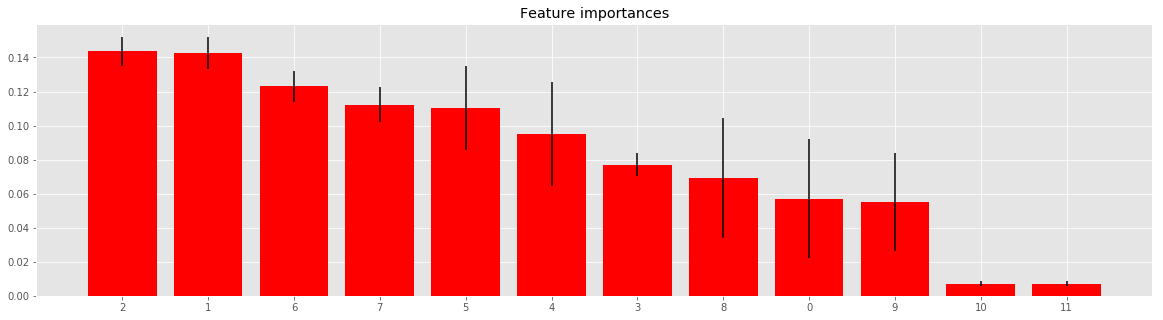

In [64]:
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [20, 5]
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

## XGBoosting

In [81]:
from xgboost import XGBClassifier

In [82]:
res = []
for lr in [0.1, 0.2, 0.3]:
    for n_e in [200, 400, 600]:
        for sub in [0.2, 0.4, 0.6]:
            gbm_7 = XGBClassifier(max_depth=4, learning_rate=lr, n_estimators=n_e,
                            objective='binary:logistic', gamma=0., 
                            max_delta_step=0., subsample=sub, colsample_bytree=0.9,
                            seed=0)
            gbm_7.fit(X_train_7, y_train_7)
            proba_gbm_7 = [x[1] for x in gbm_7.predict_proba(X_test_7)]
            fpr, tpr, thresholds = metrics.roc_curve(y_test_7, proba_gbm_7)
            res.append((lr, n_e, sub, metrics.auc(fpr, tpr)))
res

KeyboardInterrupt: 

In [83]:
res

[(0.1, 200, 0.2, 0.9664207722831201),
 (0.1, 200, 0.4, 0.9672551866706895),
 (0.1, 200, 0.6, 0.9676344690861779),
 (0.1, 400, 0.2, 0.965999047709488),
 (0.1, 400, 0.4, 0.967031443249484),
 (0.1, 400, 0.6, 0.9676198065413357),
 (0.1, 600, 0.2, 0.9654045328155633),
 (0.1, 600, 0.4, 0.9663591437066885),
 (0.1, 600, 0.6, 0.9669755853173614),
 (0.2, 200, 0.2, 0.9638713812822012),
 (0.2, 200, 0.4, 0.9660876333767764),
 (0.2, 200, 0.6, 0.9667797037617016),
 (0.2, 400, 0.2, 0.9599710101531479),
 (0.2, 400, 0.4, 0.9639877855243808),
 (0.2, 400, 0.6, 0.9648555726778755)]

In [67]:
gbm_7 = XGBClassifier(max_depth=4, learning_rate=0.3, n_estimators=200,
                            objective='binary:logistic', gamma=0., 
                            max_delta_step=0., subsample=0.5, colsample_bytree=0.9,
                            seed=0)
gbm_7.fit(X_train_7, y_train_7)
print(classification_report(gbm_7.predict(X_test_7), y_test_7))

              precision    recall  f1-score   support

       False       1.00      0.99      1.00    124089
        True       0.04      0.35      0.07       112

   micro avg       0.99      0.99      0.99    124201
   macro avg       0.52      0.67      0.54    124201
weighted avg       1.00      0.99      1.00    124201



In [68]:
proba_gbm_7 = [x[1] for x in gbm_7.predict_proba(X_test_7)]
fpr, tpr, thresholds = metrics.roc_curve(y_test_7, proba_gbm_7)
metrics.auc(fpr, tpr)

0.9195704046658044

In [69]:
gbm_14 = XGBClassifier(max_depth=4, learning_rate=0.3, n_estimators=200,
                            objective='binary:logistic', gamma=0., 
                            max_delta_step=0., subsample=0.5, colsample_bytree=0.9,
                            seed=0)
gbm_14.fit(X_train_14, y_train_14)
print(classification_report(gbm_14.predict(X_test_14), y_test_14))

              precision    recall  f1-score   support

       False       1.00      0.99      0.99    124059
        True       0.04      0.39      0.08       142

   micro avg       0.99      0.99      0.99    124201
   macro avg       0.52      0.69      0.54    124201
weighted avg       1.00      0.99      0.99    124201



In [70]:
proba_gbm_14 = [x[1] for x in gbm_14.predict_proba(X_test_14)]
fpr, tpr, thresholds = metrics.roc_curve(y_test_14, proba_gbm_14)
metrics.auc(fpr, tpr)

0.9138840426659008

## Predict Submission

In [84]:
submission = pd.read_csv('submission_sample.csv')

In [85]:
submission.user_purchase_binary_7_days = 0
submission.user_purchase_binary_14_days = 0

In [86]:
submission.head()

,user_id_hash,user_purchase_binary_7_days,user_purchase_binary_14_days
0,e469dfaed039ead9110165d9bc457acb11609ca34057dc...,0,0
1,afcc639a324b6c598ef83d360450afa011cb2dd1358bf9...,0,0
2,fd5a7cf211d08e3e00f7be6a9df6e6ea3d2e5c22a5d9c3...,0,0
3,00bfff98b9d0329f014c2eeac7ce47cd18b2bc6e10d608...,0,0
4,0d298f3638c43e915c119d4935e1ce8d168f81b5e3e8c1...,0,0


In [87]:
purchase = events.loc[events.event=='8']
purchase_count = purchase.groupby('user_id_hash')['event'].count().to_frame()
purchase_count = purchase_count.reset_index()

In [88]:
purchase_count = purchase_count.rename(index=str, columns={"event": "purchase_count"})
purchase_count.head()

,user_id_hash,purchase_count
0,002e447aed33ed4c51a68743cc293ef2148058b6a6239e...,0
1,005c9d79cf18efc6c8b5fa767964b1def9b8e2f8abd23f...,0
2,0061b4d30e8a9935b2ebeec954ff509b4f0cb500cd725c...,0
3,00fbbf507c7d3c2f259cd3329d241c29d35712e2d4699f...,0
4,0107a0017873efc2dea9a9155832363ceacf6fe97bd428...,0


In [89]:
last_7_events = events.loc[(events.event_timestamp > '2018-12-08 00:00') & (events.event_timestamp > '2018-12-15 00:00')]
last_14_events = events.loc[(events.event_timestamp > '2018-12-01 00:00') & (events.event_timestamp < '2018-12-15 00:00')]


In [90]:
purchase_7 = last_7_events.loc[last_7_events.event=='8']
purchase_count_7 = purchase_7.groupby('user_id_hash')['event'].count().to_frame()
purchase_count_7 = purchase_count_7.reset_index()
purchase_count_7 = purchase_count_7.rename(index=str, columns={"event": "purchase_count_7"})

In [91]:
purchase_value_7 = last_7_events.groupby('user_id_hash')['event_value'].agg(['sum', 'mean'])\
                     .rename(columns={'sum': 'sum_value_7', 'mean': 'mean_value_7'})
purchase_value_7.fillna(0, inplace=True)

In [92]:
purchase_14 = last_14_events.loc[last_14_events.event=='8']
purchase_count_14 = purchase_14.groupby('user_id_hash')['event'].count().to_frame()
purchase_count_14 = purchase_count_14.reset_index()
purchase_count_14 = purchase_count_14.rename(index=str, columns={"event": "purchase_count_14"})

In [93]:
purchase_value_14 = last_14_events.groupby('user_id_hash')['event_value'].agg(['sum', 'mean'])\
                     .rename(columns={'sum': 'sum_value_14', 'mean': 'mean_value_14'})
purchase_value_14.fillna(0, inplace=True)

In [94]:
pur_npur_ratio = events[events.event=='8'].groupby('user_id_hash').size()/events.groupby('user_id_hash').size()
pur_npur_ratio = pur_npur_ratio.to_frame().reset_index()
pur_npur_ratio.rename(columns={0: 'ratio'}, inplace=True)

In [95]:
group_event = event_data.groupby('user_id_hash')['event_value'].agg(['sum', 'mean', 'count'])\
            .rename(columns={'sum': 'sum_event', 'mean': 'mean_event_value', 'count': 'count_event'})
group_event.fillna(0, inplace=True)

In [96]:
group_event_7 = last_7_events.groupby('user_id_hash')['event_value'].agg(['sum', 'mean', 'count'])\
            .rename(columns={'sum': 'sum_event_7', 'mean': 'mean_event_value_7', 'count': 'count_event_7'})

group_event_14 = last_14_events.groupby('user_id_hash')['event_value'].agg(['sum', 'mean', 'count'])\
            .rename(columns={'sum': 'sum_event_14', 'mean': 'mean_event_value_14', 'count': 'count_event_14'})
group_event_7.fillna(0, inplace=True)
group_event_14.fillna(0, inplace=True)


In [97]:
grouped = sessions.groupby('user_id_hash')
user_agg = grouped['previous_sessions_duration'].agg(['sum', 'mean', 'count'])\
                   .rename(columns={'sum': 'sum_duration', 'mean': 'mean_duration', 'count': 'count_session'})
user_agg.fillna(0, inplace=True)

In [98]:
last_7_sessions = sessions.loc[(sessions.start_timestamp > '2018-12-08 00:00') & (sessions.start_timestamp < '2018-12-15 00:00')]
last_14_sessions = sessions.loc[(sessions.start_timestamp > '2018-12-01 00:00') & (sessions.start_timestamp > '2018-12-15 00:00')]


In [99]:
grouped_7 = last_7_sessions.groupby('user_id_hash')
user_agg_7 = grouped_7['previous_sessions_duration'].agg(['sum', 'mean', 'count'])\
                   .rename(columns={'sum': 'sum_duration_7', 'mean': 'mean_duration_7', 'count': 'count_session_7'})

grouped_14 = last_14_sessions.groupby('user_id_hash')
user_agg_14 = grouped_14['previous_sessions_duration'].agg(['sum', 'mean', 'count'])\
                   .rename(columns={'sum': 'sum_duration_14', 'mean': 'mean_duration_14', 'count': 'count_session_14'})


In [100]:
user_agg_7.fillna(0, inplace=True)
user_agg_14.fillna(0, inplace=True)

In [101]:
submission.columns

Index(['user_id_hash', 'user_purchase_binary_7_days',
       'user_purchase_binary_14_days'],
      dtype='object')

In [102]:
sub = submission.user_id_hash.to_frame()

In [103]:
sub.head()

,user_id_hash
0,e469dfaed039ead9110165d9bc457acb11609ca34057dc...
1,afcc639a324b6c598ef83d360450afa011cb2dd1358bf9...
2,fd5a7cf211d08e3e00f7be6a9df6e6ea3d2e5c22a5d9c3...
3,00bfff98b9d0329f014c2eeac7ce47cd18b2bc6e10d608...
4,0d298f3638c43e915c119d4935e1ce8d168f81b5e3e8c1...


In [133]:
len(submission)

312568

In [138]:
len(new_df)

312568

In [ ]:
len()

In [135]:
dfs_sub = [pur_npur_ratio, os_enc, purchase_count, purchase_count_7, purchase_count_14, 
           purchase_value, purchase_value_7, purchase_value_14, 
           group_event, group_event_7, group_event_14, user_agg, user_agg_7, user_agg_14, target_df]

In [136]:
df_sub = reduce(lambda left,right: pd.merge(left,right,on='user_id_hash'), dfs_sub)

In [137]:
new_df = pd.merge(sub, df_sub, how='left', on='user_id_hash')

In [139]:
new_df.fillna(0, inplace=True)

In [140]:
new_df.head()

,user_id_hash,ratio,Android OS,iOS,purchase_count,purchase_count_7,purchase_count_14,sum_value,mean_value,sum_value_7,...,mean_duration,count_session,sum_duration_7,mean_duration_7,count_session_7,sum_duration_14,mean_duration_14,count_session_14,one_week_purchase,two_week_purchase
0,e469dfaed039ead9110165d9bc457acb11609ca34057dc...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,356544.00,2.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False
1,afcc639a324b6c598ef83d360450afa011cb2dd1358bf9...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False
2,fd5a7cf211d08e3e00f7be6a9df6e6ea3d2e5c22a5d9c3...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,388631.25,4.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False
3,00bfff98b9d0329f014c2eeac7ce47cd18b2bc6e10d608...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9200582.90,10.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False
4,0d298f3638c43e915c119d4935e1ce8d168f81b5e3e8c1...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False


In [141]:
len(new_df)

312568

In [143]:
X_sub = new_df.iloc[:,1:-2]

In [152]:
gbm_7 = XGBClassifier(max_depth=4, learning_rate=0.1, n_estimators=200,
                            objective='binary:logistic', gamma=0., 
                            max_delta_step=0., subsample=0.8, colsample_bytree=0.9,
                            seed=0)
gbm_7.fit(X, y_7)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9, gamma=0.0, learning_rate=0.1,
       max_delta_step=0.0, max_depth=4, min_child_weight=1, missing=None,
       n_estimators=200, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=0, silent=True,
       subsample=0.8)

In [153]:
gbm_14 = XGBClassifier(max_depth=4, learning_rate=0.1, n_estimators=200,
                            objective='binary:logistic', gamma=0., 
                            max_delta_step=0., subsample=0.8, colsample_bytree=0.9,
                            seed=0)
gbm_14.fit(X, y_14)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9, gamma=0.0, learning_rate=0.1,
       max_delta_step=0.0, max_depth=4, min_child_weight=1, missing=None,
       n_estimators=200, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=0, silent=True,
       subsample=0.8)

In [154]:
X_sub.columns

Index(['ratio', 'Android OS', 'iOS', 'purchase_count', 'purchase_count_7',
       'purchase_count_14', 'sum_value', 'mean_value', 'sum_value_7',
       'mean_value_7', 'sum_value_14', 'mean_value_14', 'sum_event',
       'mean_event_value', 'count_event', 'sum_event_7', 'mean_event_value_7',
       'count_event_7', 'sum_event_14', 'mean_event_value_14',
       'count_event_14', 'sum_duration', 'mean_duration', 'count_session',
       'sum_duration_7', 'mean_duration_7', 'count_session_7',
       'sum_duration_14', 'mean_duration_14', 'count_session_14'],
      dtype='object')

In [155]:
proba_7 = [x[1] for x in gbm_7.predict_proba(X_sub)]
proba_14 = [x[1] for x in gbm_14.predict_proba(X_sub)]
submission['user_purchase_binary_7_days'] = proba_7
submission['user_purchase_binary_14_days'] = proba_14

In [156]:
submission.to_csv('submission.csv', index=False)

In [157]:
df.head()

,user_id_hash,ratio,Android OS,iOS,purchase_count,purchase_count_7,purchase_count_14,sum_value,mean_value,sum_value_7,...,mean_duration,count_session,sum_duration_7,mean_duration_7,count_session_7,sum_duration_14,mean_duration_14,count_session_14,one_week_purchase,two_week_purchase
0,002e447aed33ed4c51a68743cc293ef2148058b6a6239e...,0.0,0,1,0,0,0,0.0,0.0,0.0,...,1889284.25,4,0.0,0.0,0,0.0,0.0,0,False,False
1,005c9d79cf18efc6c8b5fa767964b1def9b8e2f8abd23f...,0.0,1,0,0,0,0,0.0,0.0,0.0,...,0.00,1,0.0,0.0,0,0.0,0.0,0,False,False
2,0061b4d30e8a9935b2ebeec954ff509b4f0cb500cd725c...,0.0,0,1,0,0,0,0.0,0.0,0.0,...,0.00,1,0.0,0.0,0,0.0,0.0,0,False,False
3,00fbbf507c7d3c2f259cd3329d241c29d35712e2d4699f...,0.0,0,1,0,0,0,0.0,0.0,0.0,...,645705.50,2,0.0,0.0,0,0.0,0.0,0,False,False
4,0107a0017873efc2dea9a9155832363ceacf6fe97bd428...,0.0,0,1,0,0,0,0.0,0.0,0.0,...,0.00,1,0.0,0.0,0,0.0,0.0,0,False,False


In [158]:
df.to_csv('train.csv', index=False)
new_df.iloc[:,:-2].to_csv('sub.csv', index=False)

In [159]:
df.to_csv('train.csv', index=False)